# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier


---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'train.p'
validation_file= 'valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**


### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of validation examples
n_validation = X_valid.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(list(y_train) + list(y_valid) + list(y_test)))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). 

In [3]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
#importing some useful packages
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

In [4]:
import random
train_sample = [random.randint(0, n_train - 1) for i in range(20)]

In [5]:
import pandas as pd
signnames = pd.read_csv('signnames.csv')

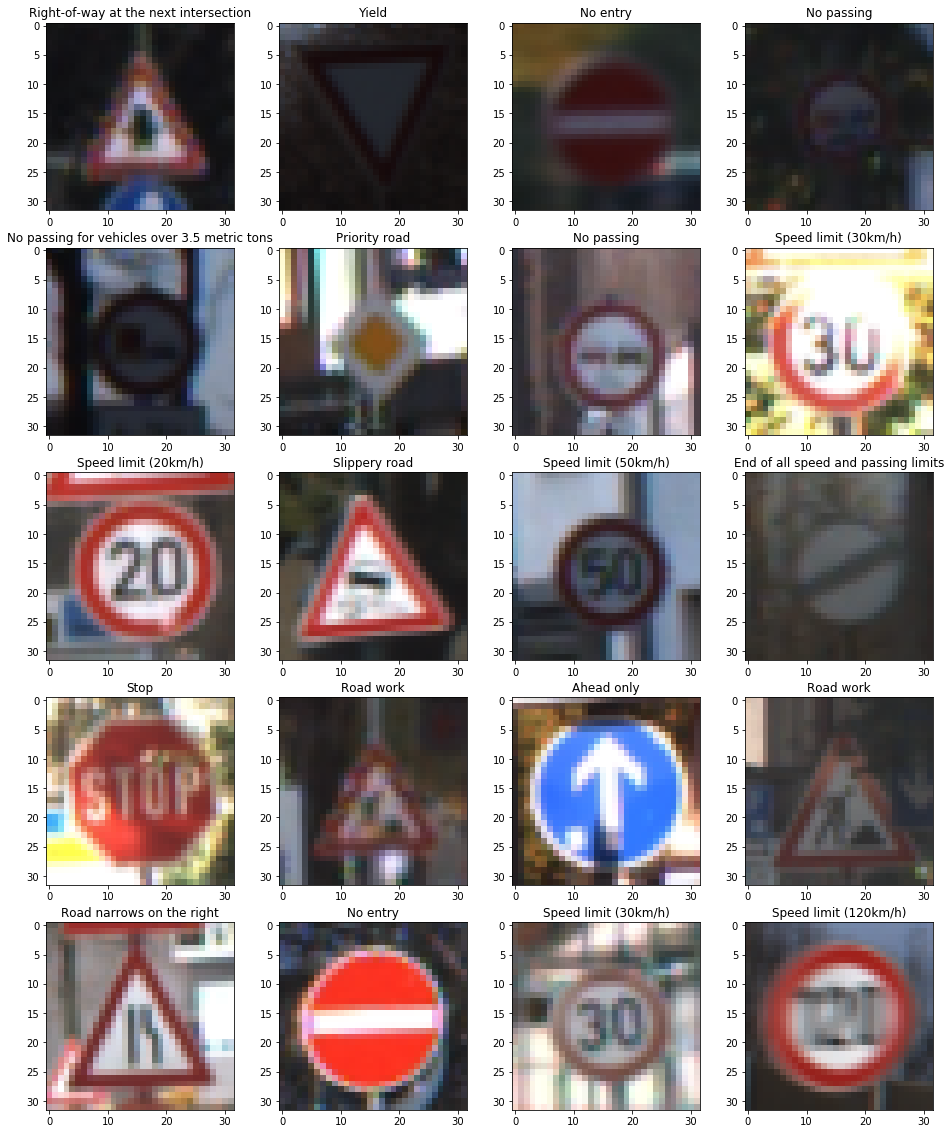

In [6]:
k = 1
plt.figure(figsize=(16, 20))
for i in train_sample:
    plt.subplot(5, 4, k)
    plt.imshow(X_train[i])
    title = signnames[signnames['ClassId'] == y_train[i]]['SignName'].values[0]
    plt.title(title)
    k = k + 1

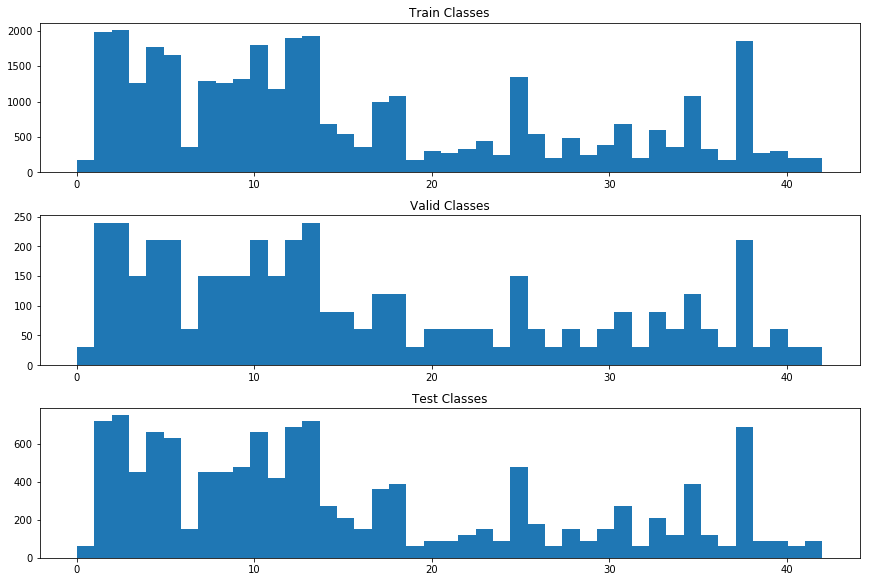

In [7]:
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
n, bins, patches = plt.hist(y_train, bins = 43)
plt.title('Train Classes')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.subplot(3, 1, 2)
n, bins, patches = plt.hist(y_valid, bins = 43)
plt.title('Valid Classes')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.subplot(3, 1, 3)
n, bins, patches = plt.hist(y_test, bins = 43)
plt.title('Test Classes')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. 

### Pre-process the Data Set 

In [8]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

#Increase contrast
def contrast_img(img):
    img_out = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img_out[:, :, 0] = cv2.equalizeHist(img_out[:, :, 0])
    return img_out[:, :, 0]

In [9]:
#Random rotate
def rotate_img(img):
    c_x, c_y = int(img.shape[0]/2), int(img.shape[1]/2)
    angle = 30.0*np.random.rand() - 15
    Mat = cv2.getRotationMatrix2D((c_x, c_y), angle, 1.0)
    return cv2.warpAffine(img, Mat, img.shape[:2])

#Random scale
def scale_img(img):
    scale= 0.4*np.random.rand() + 1.0
    new=cv2.resize(img, None, fx=1, fy=scale, interpolation = cv2.INTER_CUBIC)
    
    #restore original size
    d = int((new.shape[1] - img.shape[0])/2)
    end = img.shape[1] - d
    out = new[d:end, :, :]
    return out

#Random inlear translation
def lin_img(img, s=1.0, m=0.0):
    img2 = cv2.multiply(img, np.array([s]))
    return cv2.add(img2, np.array([m]))

def transl_img(img, s=1.0):
    m = 127.0*(1.0-s)
    return lin_img(img, s, m)

def augment_img(img):
    img = rotate_img(img)
    img = scale_img(img)
    img = transl_img(img, 1.8*np.random.rand() + 0.2)
    return contrast_img(img)

A sample image

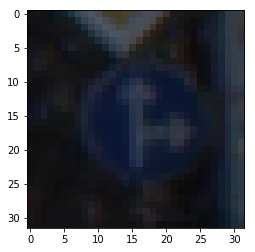

In [22]:
plt.imshow(X_train[1000])

Augmented sample image

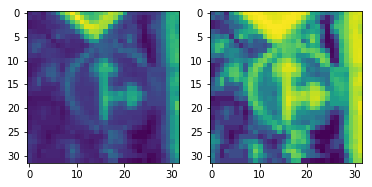

In [23]:
img = X_train[1000]
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))
plt.subplot(1, 2, 2)
img_out = contrast_img(img)
plt.imshow(img_out)

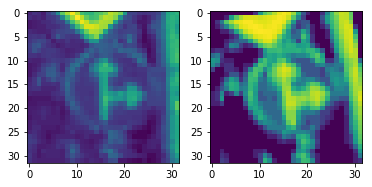

In [24]:
aug = augment_img(img)
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))
plt.subplot(1, 2, 2)
plt.imshow(aug)

In [10]:
#generate a lot more data, 10 times
X_train_more = []
y_train_more = []

for i in range(X_train.shape[0]):
    img = X_train[i]
    label = y_train[i]
    
    img_out = contrast_img(img)
    img_out.shape = (1,) + img_out.shape + (1,)
    X_train_more.append(img_out)
    y_train_more.append(label)
    
    for k in range(10):
        img_out = augment_img(img)
        img_out.shape = (1,) + img_out.shape + (1,)
        X_train_more.append(img_out)
        y_train_more.append(label)

In [11]:
#transform valid and test data
X_test_more = []
X_valid_more = []
for i in range(X_valid.shape[0]):
    img = X_valid[i]
    img = contrast_img(img)
    img.shape = (1,) + img.shape + (1,)
    X_valid_more.append(img)
    
for i in range(X_test.shape[0]):
    img = X_test[i]
    img = contrast_img(img)
    img.shape = (1,) + img.shape + (1,)
    X_test_more.append(img)

In [12]:
X_test = np.concatenate(X_test_more)
X_train = np.concatenate(X_train_more)
X_valid = np.concatenate(X_valid_more)
y_train = np.array(y_train_more)

In [13]:
X_train[0].shape

(32, 32, 1)

In [14]:
from sklearn.utils import shuffle


In [15]:
X_train.shape

(382789, 32, 32, 1)

### Setup TensorFlow

In [16]:
import tensorflow as tf

EPOCHS = 70
BATCH_SIZE = 128

### Model Architecture

In [17]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 200.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 200), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(200))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)
    
    # Let's add dropout since we expereinced overfitting
    fc1 = tf.nn.dropout(fc1, keep_prob) 
    
    # SOLUTION: Layer 4: Fully Connected. Input = 200. Output = 100.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(200, 100), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(100))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)
    
    # Dropout
    fc2 = tf.nn.dropout(fc2, keep_prob)
    
    # SOLUTION: Layer 5: Fully Connected. Input = 100. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(100, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [18]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
keep_prob = tf.placeholder(tf.float32)

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [19]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.
rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [20]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [31]:
train_acc_list = []
valid_acc_list = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)

    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.7})
        train_accuracy = evaluate(X_train, y_train)    
        validation_accuracy = evaluate(X_valid, y_valid)
        train_acc_list.append(train_accuracy)
        valid_acc_list.append(validation_accuracy)
        print("EPOCH {} ...".format(i+1))
        print()       
    saver.save(sess, './models/lenet1')
    print("Model saved")
    

Training...

EPOCH 1 ...

EPOCH 2 ...

EPOCH 3 ...

EPOCH 4 ...

EPOCH 5 ...

EPOCH 6 ...

EPOCH 7 ...

EPOCH 8 ...

EPOCH 9 ...

EPOCH 10 ...

EPOCH 11 ...

EPOCH 12 ...

EPOCH 13 ...

EPOCH 14 ...

EPOCH 15 ...

EPOCH 16 ...

EPOCH 17 ...

EPOCH 18 ...

EPOCH 19 ...

EPOCH 20 ...

EPOCH 21 ...

EPOCH 22 ...

EPOCH 23 ...

EPOCH 24 ...

EPOCH 25 ...

EPOCH 26 ...

EPOCH 27 ...

EPOCH 28 ...

EPOCH 29 ...

EPOCH 30 ...

EPOCH 31 ...

EPOCH 32 ...

EPOCH 33 ...

EPOCH 34 ...

EPOCH 35 ...

EPOCH 36 ...

EPOCH 37 ...

EPOCH 38 ...

EPOCH 39 ...

EPOCH 40 ...

EPOCH 41 ...

EPOCH 42 ...

EPOCH 43 ...

EPOCH 44 ...

EPOCH 45 ...

EPOCH 46 ...

EPOCH 47 ...

EPOCH 48 ...

EPOCH 49 ...

EPOCH 50 ...

EPOCH 51 ...

EPOCH 52 ...

EPOCH 53 ...

EPOCH 54 ...

EPOCH 55 ...

EPOCH 56 ...

EPOCH 57 ...

EPOCH 58 ...

EPOCH 59 ...

EPOCH 60 ...

EPOCH 61 ...

EPOCH 62 ...

EPOCH 63 ...

EPOCH 64 ...

EPOCH 65 ...

EPOCH 66 ...

EPOCH 67 ...

EPOCH 68 ...

EPOCH 69 ...

EPOCH 70 ...

Model saved


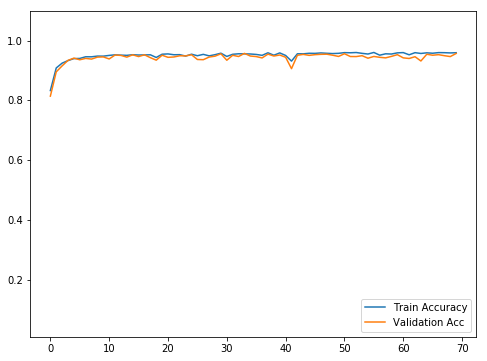

In [32]:
t = range(EPOCHS)
plt.figure(figsize=(8,6))
plt.plot(t, train_acc_list,  t, valid_acc_list)
plt.ylim([.01,1.1])
plt.legend(('Train Accuracy','Validation Acc'),scatterpoints=1,loc='lower right',fontsize=10,)
plt.show()

In [33]:
with tf.Session() as sess:
    saver.restore(sess, './models/lenet1')

    test_accuracy = sess.run(accuracy_operation, feed_dict={x: X_test, y: y_test, keep_prob : 1.0})

print('Test Accuracy: {:.2f}'.format(test_accuracy))

Test Accuracy: 0.93


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [59]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import os

In [60]:
web_images = os.listdir("webimages/")

In [61]:
web_input = [mpimg.imread("./webimages/" + image) for image in web_images]

In [62]:
web_resize = []
for image in web_images:
    orig = mpimg.imread("./webimages/" + image)
    resized = cv2.resize(orig, (32, 32))
    web_resize.append(resized)

In [63]:
web_out = np.zeros((len(web_resize), 32, 32, 1), np.float64)
i = 0
for img in web_resize:
    out = contrast_img(web_resize[i])
    web_out[i] = out.reshape(32, 32, 1)
    i += 1

In [64]:
web_out.shape

(5, 32, 32, 1)

### Predict the Sign Type for Each Image

In [65]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
with tf.Session() as sess:
    saver.restore(sess, './models/lenet1')
    web_classes = sess.run(logits, feed_dict={x: web_out, keep_prob : 1.0})
    web_softmax = sess.run(tf.nn.softmax(logits), feed_dict={x: web_out, keep_prob : 1.0})

### Analyze Performance

In [66]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [67]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
with tf.Session() as sess:
    predicts = sess.run(tf.nn.top_k(web_softmax, k=5, sorted=True))

In [68]:
predicts

TopKV2(values=array([[  3.39894176e-01,   1.21048145e-01,   9.35769454e-02,
          7.60162398e-02,   6.94332570e-02],
       [  6.86651230e-01,   1.01600453e-01,   5.19246086e-02,
          3.95330638e-02,   2.25645415e-02],
       [  1.00000000e+00,   2.60217130e-12,   2.46783307e-13,
          7.88955758e-23,   2.42491089e-24],
       [  4.55692977e-01,   3.07067543e-01,   5.42154238e-02,
          2.10460648e-02,   2.02396084e-02],
       [  2.94961154e-01,   1.11262776e-01,   6.59620464e-02,
          5.51098324e-02,   5.31027801e-02]], dtype=float32), indices=array([[39, 13, 28, 15, 32],
       [25, 10, 20, 11, 21],
       [18, 27, 26, 31, 25],
       [12, 23,  2, 15,  9],
       [13,  5, 20, 34, 28]], dtype=int32))

In [69]:
n_img = len(predicts[0][0])

Web Image 1 :


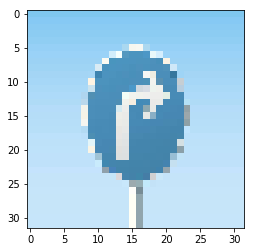

Keep left :  0.339894
Yield :  0.121048
Children crossing :  0.0935769
No vehicles :  0.0760162
End of all speed and passing limits :  0.0694333


Web Image 2 :


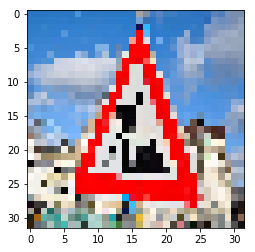

Road work :  0.686651
No passing for vehicles over 3.5 metric tons :  0.1016
Dangerous curve to the right :  0.0519246
Right-of-way at the next intersection :  0.0395331
Double curve :  0.0225645


Web Image 3 :


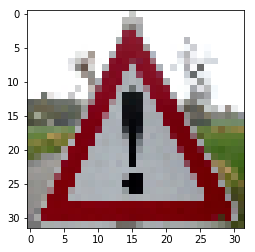

General caution :  1.0
Pedestrians :  2.60217e-12
Traffic signals :  2.46783e-13
Wild animals crossing :  7.88956e-23
Road work :  2.42491e-24


Web Image 4 :


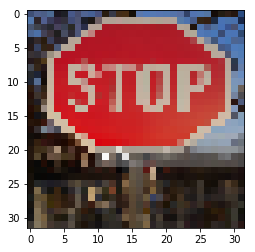

Priority road :  0.455693
Slippery road :  0.307068
Speed limit (50km/h) :  0.0542154
No vehicles :  0.0210461
No passing :  0.0202396


Web Image 5 :


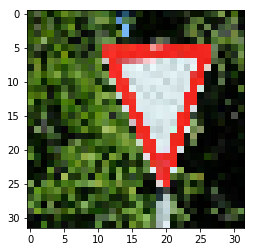

Yield :  0.294961
Speed limit (80km/h) :  0.111263
Dangerous curve to the right :  0.065962
Turn left ahead :  0.0551098
Children crossing :  0.0531028




In [70]:
for i in range(n_img):
    print('Web Image', i + 1, ':')
    plt.imshow(web_resize[i])
    plt.show()
    for k in range(5):
        pred_class = predicts[1][i][k]
        print(signnames[signnames['ClassId'] == pred_class]['SignName'].values[0], ': ',predicts[0][i][k])
    print('\n')